To begin the project, I'm constructing an EDA to understand what all this data means/represents. Also will help me explore/learn world of ML.

**Key questions I aim to answer**
- What each dataset looks like on its own: bitcoin prices/trends, Reddit data over time, etc.
- How I will match bitcoin alignment to the Reddit data
- Whether Reddit signals actually say anything / whether there is a correlation vs. if the project is just my imaginative fluff

I also just want a more solid grasp of how to use the packages that I'll be using.

For sake of simplification, I will only be looking at a limited dataset downloaded from Kaggle. This looks at a specific collection of Reddit posts (don't really care which at this point) and examines only a few days in the year 2022.


In [25]:
# Imports, setting up packages.
import pandas as pd
import numpy as np

In [ ]:
# Reddit sentiment data. 

# Load Reddit CSV, obtained through Kaggle.
reddit = pd.read_csv("data/CryptoCurrency.csv") # I obtained this through Kaggle.
reddit.head()

# Define positive/negative word lists (I aim to upgrade this later, but this is a starting point)
positive_words = ["good", "great", "bull", "moon", "pump", "gain", "profit", "win"]
negative_words = ["bad", "bear", "dump", "loss", "crash", "fail", "down", "sell"]

# Analyzes how many of these words are in each post and generates a score. Also normalizes it by post length so long posts don't have excise impact.
def simple_sentiment(text):
    words = str(text).lower().split()
    happiness = 0
    for w in words:
        if w in positive_words:
            happiness += 1
        elif w in negative_words:
            happiness -= 1
    return happiness / max(len(words), 1)

# Apply sentiment method.
reddit['sentiment'] = reddit['title'].apply(simple_sentiment)

# Must extract datetime to Python format.
import datetime as dt
reddit['timestamp'] = pd.to_datetime(reddit['timestamp'])
reddit['date'] = reddit['timestamp'].dt.date  

# Aggregate daily.
daily_reddit = reddit.groupby('date').apply(
    lambda x: pd.Series({
        'avg_sentiment': (x['sentiment'] * x['score']).sum() / x['score'].sum(),
        'post_count': len(x)
    })
).reset_index()

# Set datetime column format correctly for later.
daily_reddit['date'] = pd.to_datetime(daily_reddit['date'])

# I also want to figure out the date range for this data set to get the crypto values. 
start_date = reddit['date'].min()
end_date = reddit['date'].max()


In [ ]:
# Bitcoin price data.

import yfinance as yf

# Loads in Bitcoin price data.
btc = yf.download("BTC-USD", start="2022-12-11", end="2026-12-19")

# To check what the column names were before proceeding...
# print(btc.columns)
# print(type(btc.columns))

# Close / price / return info.
btc = btc[["Close"]].rename(columns={"Close": "price"})
btc["return"] = btc["price"].pct_change(); # Computes daily returns.
btc = btc.reset_index() # Gets a date column.
btc.dropna(inplace=True) 

# Flattens BTC for usability later on.
btc.columns = [col[0] if isinstance(col, tuple) else col for col in btc.columns]
btc.rename(columns={'Date': 'date'}, inplace=True)
btc = btc[['date', 'price', 'return']] 

btc.head()

In [100]:
# Merge Reddit + BTC data.

data = pd.merge(
    btc[['date','price','return']],
    daily_reddit[['date','avg_sentiment','post_count']],
    on='date',
    how='inner'
)
data.dropna(inplace=True)

print("Merged dataset head:")
print(data.head())

Merged dataset head:
        date         price    return  avg_sentiment  post_count
0 2022-12-12  17206.437500  0.005978      -0.006835        37.0
1 2022-12-13  17781.318359  0.033411       0.000014       169.0
2 2022-12-14  17815.650391  0.001931       0.000070       157.0
3 2022-12-15  17364.865234 -0.025303      -0.000064       181.0
4 2022-12-16  16647.484375 -0.041312      -0.000733       152.0


In [102]:
# Now analyzing the data.

# 1 = BTC goes up next day, 0 = BTC goes down or stays flat
data['target'] = (data['return'].shift(-1) > 0).astype(int)
data.dropna(inplace=True)

print(data.head())


        date         price    return  avg_sentiment  post_count  target
0 2022-12-12  17206.437500  0.005978      -0.006835        37.0       1
1 2022-12-13  17781.318359  0.033411       0.000014       169.0       1
2 2022-12-14  17815.650391  0.001931       0.000070       157.0       0
3 2022-12-15  17364.865234 -0.025303      -0.000064       181.0       0
4 2022-12-16  16647.484375 -0.041312      -0.000733       152.0       1


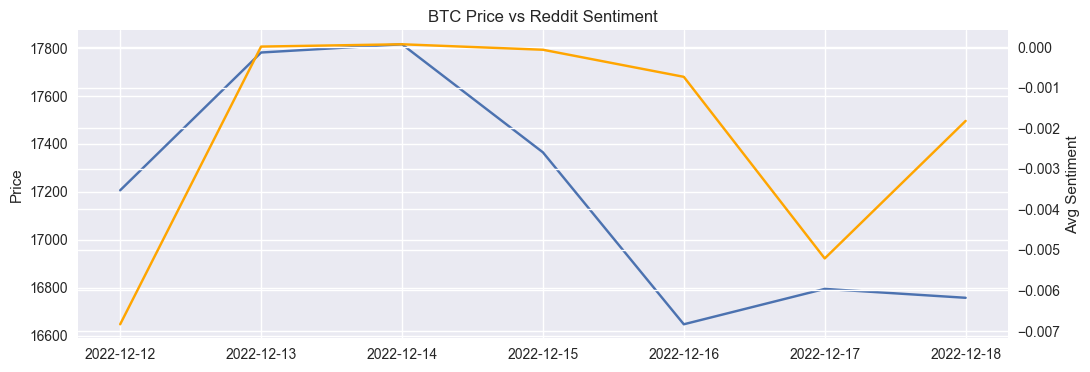

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

# BTC price vs sentiment
fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(data['date'], data['price'], label='BTC Price')
ax1.set_ylabel("Price")
ax2 = ax1.twinx()
ax2.plot(data['date'], data['avg_sentiment'], color='orange', label='Reddit Sentiment')
ax2.set_ylabel("Avg Sentiment")
plt.title("BTC Price vs Reddit Sentiment")
plt.show()

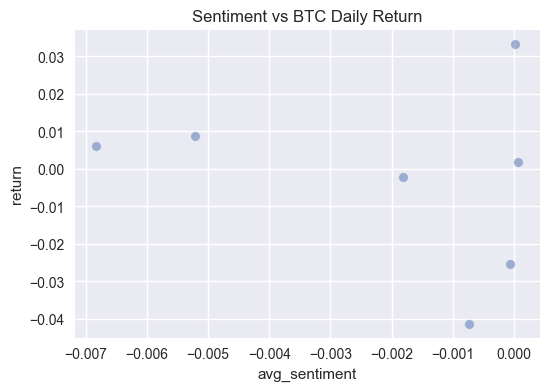

In [110]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='avg_sentiment', y='return', data=data, alpha=0.5)
plt.title("Sentiment vs BTC Daily Return")
plt.show()

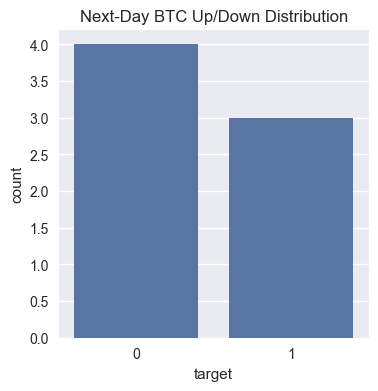

In [111]:
plt.figure(figsize=(4,4))
sns.countplot(x='target', data=data)
plt.title("Next-Day BTC Up/Down Distribution")
plt.show()